In [1]:
# Importing all the necessary libraries needed throughout the study
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
import numpy as np
from scipy import signal
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# processing, segmenting and extracting band powers of calibration and feedback dfs to create train and test datasets
train_dfs = []
test3_dfs = []

excluded_numbers = [20, 35, 39, 40, 53, 62, 64]
calibration_dfs = r"C:\Users\90537\Desktop\S10_eeg_Calibration.csv"
feedback3_dfs = r"C:\Users\90537\Desktop\Subject10_eeg_4.csv"

def band_power(data):
    frequency_bands = {
        'DELTA': [0.5, 3.5],
        'THETA': [4, 7],
        'ALPHA': [8, 13],
        'BETA': [13, 25],
        'GAMMA': [25, 48]
    }
    fs = 250
    results = {}
    for column in data.columns:
        x = data[column].values
        frequencies, psd = signal.welch(x, fs, nperseg=1024)
        for band, freqrange in frequency_bands.items():
            freq_indices = np.logical_and(frequencies >= freqrange[0], frequencies <= freqrange[1])
            p = np.trapz(psd[freq_indices], frequencies[freq_indices])
            results[f"{band}_{column}"] = p
    return pd.DataFrame([results])

# processing train datasets
subject_df = pd.read_csv(calibration_dfs)
motor_imagery_subject_df = subject_df[(subject_df["TimeStamp"] >= 1) & (subject_df["TimeStamp"] < 5)]
motor_imagery_subject_df['segment'] = ((motor_imagery_subject_df['TimeStamp'] // 1) + (motor_imagery_subject_df['trial'] - 1) * 4).astype(int)
labels = motor_imagery_subject_df.groupby('segment')['class'].first().values
motor_imagery_subject_df = motor_imagery_subject_df.drop(["TimeStamp", "trial", "class"], axis=1)

segment_band_powers = []
for segment in motor_imagery_subject_df['segment'].unique():
    segment_data = motor_imagery_subject_df[motor_imagery_subject_df['segment'] == segment].drop(columns=['segment'])
    band_powers = band_power(segment_data)
    segment_band_powers.append(band_powers)
  
train_dataset = pd.concat(segment_band_powers, ignore_index=True)
train_dataset["label"] = labels
train_dfs.append(train_dataset)

# processing test dataset 3
subject_df = pd.read_csv(feedback3_dfs)
motor_imagery_subject_df = subject_df[(subject_df["TimeStamp"] >= 1) & (subject_df["TimeStamp"] < 5)]
motor_imagery_subject_df['segment'] = ((motor_imagery_subject_df['TimeStamp'] // 1) + (motor_imagery_subject_df['trial'] - 1) * 4).astype(int)
labels = motor_imagery_subject_df.groupby('segment')['class'].first().values
motor_imagery_subject_df = motor_imagery_subject_df.drop(["TimeStamp", "trial", "class"], axis=1)

segment_band_powers = []
for segment in motor_imagery_subject_df['segment'].unique():
    segment_data = motor_imagery_subject_df[motor_imagery_subject_df['segment'] == segment].drop(columns=['segment'])
    band_powers = band_power(segment_data)
    segment_band_powers.append(band_powers)
  
test3_dataset = pd.concat(segment_band_powers, ignore_index=True)
test3_dataset["label"] = labels
test3_dfs.append(train_dataset)

In [ ]:
pd.read_csv(r"C:\Users\90537\Desktop\accuracy_df.csv")

,Subject,Band Power,Model,Accuracy
0,1,ALPHA,Logistic Regression,0.60625
1,1,ALPHA,Decision Tree,0.75625
2,1,ALPHA,Random Forest,0.96875
3,1,ALPHA,KNN,0.60625
4,1,ALPHA,Naive Bayes,0.55000
5,1,ALPHA,SVC,0.65000
6,1,BETA,Logistic Regression,0.64375
7,1,BETA,Decision Tree,0.79375
8,1,BETA,Random Forest,0.96250
9,1,BETA,KNN,0.66250


In [ ]:
bands = ['ALPHA', 'BETA', 'THETA', 'GAMMA', 'DELTA']
models = {
	'Logistic Regression': LogisticRegression(max_iter=1000),
	'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_split=10),
	'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10),
	'KNN': KNeighborsClassifier(),
	'Naive Bayes': GaussianNB(),
	'SVC': SVC()
}

final_results = []

for subject_id, train_data in enumerate(train_dfs):
	X_train = train_data.drop(columns='label').values
	y_train = train_data['label'].values
	
	X_test3 = test3_dfs[subject_id].drop(columns='label').values
	y_test3 = test3_dfs[subject_id]['label'].values

	for band in bands:
		X_train_band = train_data.filter(like=band).values
		X_test3_band = test3_dfs[subject_id].filter(like=band).values
		
		accuracies = {}

		for model_name, model in models.items():
			model.fit(X_train_band, y_train)
	
			accuracies[model_name] = accuracy_score(y_test3, model.predict(X_test3_band))

		final_results = [
			{'Subject': f'{subject_id+1}', 'Band Power': band, 'Model': model, 'Accuracy': acc}
			for model, acc in accuracies.items()
		]

accuracy_df = pd.DataFrame(final_results)
accuracy_df

,Subject,Band Power,Model,Accuracy
0,1,DELTA,Logistic Regression,0.66875
1,1,DELTA,Decision Tree,0.84375
2,1,DELTA,Random Forest,0.90000
3,1,DELTA,KNN,0.70625
4,1,DELTA,Naive Bayes,0.51875
5,1,DELTA,SVC,0.53750


In [ ]:
# finding accuracies for each subject, band power and model without any feature selection method
bands = ['ALPHA', 'BETA', 'THETA', 'GAMMA', 'DELTA']
models = {
	'Logistic Regression': LogisticRegression(max_iter=1000),
	'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_split=10),
	'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10),
	'KNN': KNeighborsClassifier(),
	'Naive Bayes': GaussianNB(),
	'SVC': SVC()
}

final_results = []

for subject_id, train_data in enumerate(train_dfs):
	X_train = train_data.drop(columns='label').values
	y_train = train_data['label'].values
	
	X_test3 = test3_dfs[subject_id].drop(columns='label').values
	y_test3 = test3_dfs[subject_id]['label'].values

	for band in bands:
		X_train_band = train_data.filter(like=band).values
		X_test3_band = test3_dfs[subject_id].filter(like=band).values
		
		for model_name, model in models.items():
			model.fit(X_train_band, y_train)
	
			final_accuracy = accuracy_score(y_test3, model.predict(X_test3_band))
			
			final_results.append({
				'Subject': f'{subject_id+1}',
				'Band Power': band,
				'Model': model_name,
				'Accuracy': final_accuracy
			})

accuracy_df = pd.DataFrame(final_results)
accuracy_df

,Subject,Band Power,Model,Best Accuracy
0,1,ALPHA,Logistic Regression,0.49375
1,1,ALPHA,Decision Tree,0.45625
2,1,ALPHA,Random Forest,0.45625
3,1,ALPHA,KNN,0.52500
4,1,ALPHA,Naive Bayes,0.58750
...,...,...,...,...
1615,54,DELTA,Decision Tree,0.76250
1616,54,DELTA,Random Forest,0.93750
1617,54,DELTA,KNN,0.73750
1618,54,DELTA,Naive Bayes,0.59375


In [ ]:
# with kbest-anova
bands = ['ALPHA', 'BETA', 'THETA', 'GAMMA', 'DELTA']
models = {
	'Logistic Regression': LogisticRegression(max_iter=1000),
	'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_split=10),
	'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10),
	'KNN': KNeighborsClassifier(),
	'Naive Bayes': GaussianNB(),
	'SVC': SVC()
}

final_results = []

for subject_id, train_data in enumerate(train_dfs):
	X_train = train_data.drop(columns='label').values
	y_train = train_data['label'].values
	
	X_test3 = test3_dfs[subject_id].drop(columns='label').values
	y_test3 = test3_dfs[subject_id]['label'].values

	for band in bands:
		X_train_band = train_data.filter(like=band).values
		X_test3_band = test3_dfs[subject_id].filter(like=band).values

		best_accuracy = 0
		best_k = 0

		for k in range(1, X_train_band.shape[1] + 1):
			selector = SelectKBest(f_classif, k=k)
			X_train_selected = selector.fit_transform(X_train_band, y_train)
			X_test3_selected = selector.transform(X_test3_band)

			for model_name, model in models.items():
				model.fit(X_train_selected, y_train)
				accuracy = accuracy_score(y_test3, model.predict(X_test3_selected))

				if accuracy > best_accuracy:
					best_accuracy = accuracy
					best_k = k

		final_results.append({
			'Subject': f'{subject_id+1}',
			'Band Power': band,
			'Best K': best_k,
			'Model': model_name,
			'Best Accuracy': best_accuracy
		})

accuracies_with_kbest = pd.DataFrame(final_results)
accuracies_with_kbest

,Subject,Band Power,Model,Best K,Best Accuracy
0,1,ALPHA,Logistic Regression,14,0.63750
1,1,ALPHA,Decision Tree,8,0.61875
2,1,ALPHA,Random Forest,11,0.56875
3,1,ALPHA,KNN,10,0.54375
4,1,ALPHA,Naive Bayes,16,0.58750
...,...,...,...,...,...
1615,54,DELTA,Decision Tree,9,0.77500
1616,54,DELTA,Random Forest,14,0.91875
1617,54,DELTA,KNN,16,0.73750
1618,54,DELTA,Naive Bayes,5,0.61250


In [ ]:
# with kbest - information gain
bands = ['ALPHA', 'BETA', 'THETA', 'GAMMA', 'DELTA']
models = {
	'Logistic Regression': LogisticRegression(max_iter=1000),
	'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_split=10),
	'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10),
	'KNN': KNeighborsClassifier(),
	'Naive Bayes': GaussianNB(),
	'SVC': SVC()
}

final_results = []

for subject_id, train_data in enumerate(train_dfs):
	X_train = train_data.drop(columns='label').values
	y_train = train_data['label'].values
	
	X_test3 = test3_dfs[subject_id].drop(columns='label').values
	y_test3 = test3_dfs[subject_id]['label'].values

	for band in bands:
		X_train_band = train_data.filter(like=band).values
		X_test3_band = test3_dfs[subject_id].filter(like=band).values

		best_accuracy = 0
		best_k = 0
		
		for k in range(1, X_train_band.shape[1] + 1):
			selector = SelectKBest(mutual_info_classif, k=k)
			X_train_selected = selector.fit_transform(X_train_band, y_train)
			X_test3_selected = selector.transform(X_test3_band)

			for model_name, model in models.items():
				model.fit(X_train_selected, y_train)
				accuracy = accuracy_score(y_test3, model.predict(X_test3_selected))
				
				if accuracy > best_accuracy:
					best_accuracy = accuracy
					best_k = k

		final_results.append({
			'Subject': f'{subject_id+1}',
			'Band Power': band,
			'Best K': best_k,
			'Model': model_name,
			'Best Accuracy': best_accuracy
		})

accuracies_with_information_gain = pd.DataFrame(final_results)
accuracies_with_information_gain

,Subject,Band Power,Model,Best K,Best Accuracy
0,1,ALPHA,Logistic Regression,1,0.56875
1,1,ALPHA,Decision Tree,1,0.51875
2,1,ALPHA,Random Forest,9,0.50625
3,1,ALPHA,KNN,16,0.52500
4,1,ALPHA,Naive Bayes,11,0.59375
...,...,...,...,...,...
1615,54,DELTA,Decision Tree,11,0.84375
1616,54,DELTA,Random Forest,13,0.93750
1617,54,DELTA,KNN,1,0.74375
1618,54,DELTA,Naive Bayes,4,0.60000


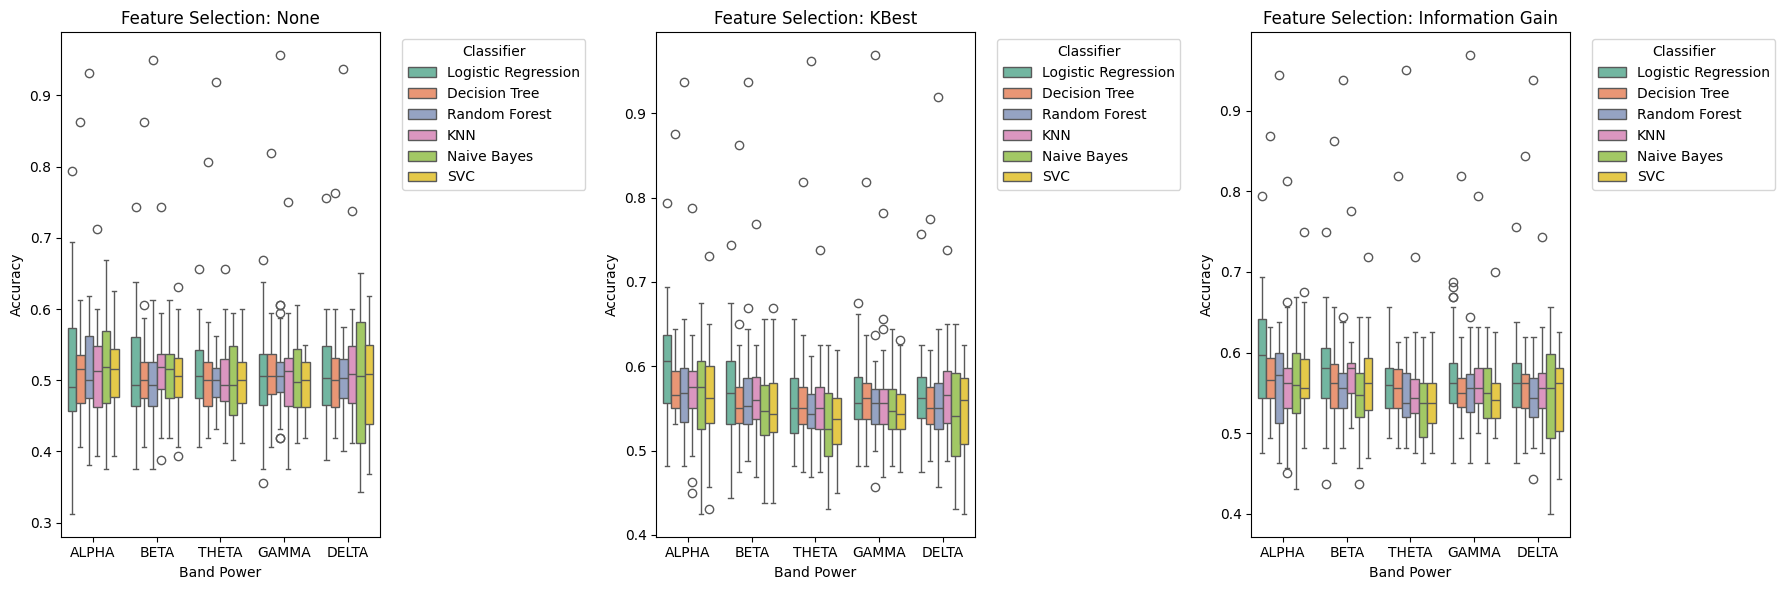

In [ ]:
# visualization of the results
accuracy_df["Feature Selection Method"] = "None"
accuracies_with_kbest["Feature Selection Method"] = "KBest"
accuracies_with_information_gain["Feature Selection Method"] = "Information Gain"
combined_df = pd.concat([accuracy_df, accuracies_with_kbest, accuracies_with_information_gain])

# Creating a box plot for comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

methods = ['None', 'KBest', 'Information Gain']
for i, method in enumerate(methods):
	method_data = combined_df[combined_df["Feature Selection Method"] == method]

	sns.boxplot(x="Band Power", y="Best Accuracy", hue="Model", data=method_data, ax=axes[i], palette="Set2")

	axes[i].set_title(f"Feature Selection: {method}")
	axes[i].set_xlabel("Band Power")
	axes[i].set_ylabel("Accuracy")
	axes[i].legend(title="Classifier", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# processing, segmenting and extracting band powers of calibration and feedback dfs to create train and test datasets
train_dfs = []
test1_dfs = []
test2_dfs = []
test3_dfs = []

calibration_dfs = [
	r"C:\Users\90537\Desktop\S10_eeg_Calibration.csv", 
	r"C:\Users\90537\Desktop\S11_eeg_Calibration.csv",
	r"C:\Users\90537\Desktop\S12_eeg_Calibration.csv", 
	r"C:\Users\90537\Desktop\S13_eeg_Calibration.csv", 
	r"C:\Users\90537\Desktop\S14_eeg_Calibration.csv"
]
feedback1_dfs = [
	r"C:\\Users\\90537\\Desktop\\Subject10_eeg_2.csv",
	r"C:\\Users\\90537\\Desktop\\Subject11_eeg_2.csv",
	r"C:\\Users\\90537\\Desktop\\Subject12_eeg_2.csv",
	r"C:\\Users\\90537\\Desktop\\Subject13_eeg_2.csv",
	r"C:\\Users\\90537\\Desktop\\Subject14_eeg_2.csv"
]
feedback2_dfs = [
	r"C:\\Users\\90537\\Desktop\\Subject10_eeg_3.csv",
	r"C:\\Users\\90537\\Desktop\\Subject11_eeg_3.csv",
	r"C:\\Users\\90537\\Desktop\\Subject12_eeg_3.csv",
	r"C:\\Users\\90537\\Desktop\\Subject13_eeg_3.csv",
	r"C:\\Users\\90537\\Desktop\\Subject14_eeg_3.csv"
]
feedback3_dfs = [
	r"C:\\Users\\90537\\Desktop\\Subject10_eeg_4.csv",
	r"C:\\Users\\90537\\Desktop\\Subject11_eeg_4.csv",
	r"C:\\Users\\90537\\Desktop\\Subject12_eeg_4.csv",
	r"C:\\Users\\90537\\Desktop\\Subject13_eeg_4.csv",
	r"C:\\Users\\90537\\Desktop\\Subject14_eeg_4.csv"
]

def band_power(data):
	frequency_bands = {
		'DELTA': [0.5, 3.5],
		'THETA': [4, 7],
		'ALPHA': [8, 13],
		'BETA': [13, 25],
		'GAMMA': [25, 48]
	}
	fs = 250
	results = {}
	for column in data.columns:
		x = data[column].values
		frequencies, psd = signal.welch(x, fs, nperseg=1024)
		for band, freqrange in frequency_bands.items():
			freq_indices = np.logical_and(frequencies >= freqrange[0], frequencies <= freqrange[1])
			p = np.trapz(psd[freq_indices], frequencies[freq_indices])
			results[f"{band}_{column}"] = p
	return pd.DataFrame([results])

# processing train datasets
for calibration_df in calibration_dfs:
	subject_df = pd.read_csv(calibration_df)
	motor_imagery_subject_df = subject_df[(subject_df["TimeStamp"] >= 1) & (subject_df["TimeStamp"] < 5)]
	motor_imagery_subject_df['segment'] = ((motor_imagery_subject_df['TimeStamp'] // 1) + (motor_imagery_subject_df['trial'] - 1) * 4).astype(int)
	labels = motor_imagery_subject_df.groupby('segment')['class'].first().values
	motor_imagery_subject_df = motor_imagery_subject_df.drop(["TimeStamp", "trial", "class"], axis=1)

	segment_band_powers = []
	for segment in motor_imagery_subject_df['segment'].unique():
		segment_data = motor_imagery_subject_df[motor_imagery_subject_df['segment'] == segment].drop(columns=['segment'])
		band_powers = band_power(segment_data)
		segment_band_powers.append(band_powers)
  
	train_dataset = pd.concat(segment_band_powers, ignore_index=True)
	train_dataset["label"] = labels
	train_dfs.append(train_dataset)

# processing test dataset 1
for feedback1_df in feedback1_dfs:
	subject_df = pd.read_csv(feedback1_df)
	motor_imagery_subject_df = subject_df[(subject_df["TimeStamp"] >= 1) & (subject_df["TimeStamp"] < 5)]
	motor_imagery_subject_df['segment'] = ((motor_imagery_subject_df['TimeStamp'] // 1) + (motor_imagery_subject_df['trial'] - 1) * 4).astype(int)
	labels = motor_imagery_subject_df.groupby('segment')['class'].first().values
	motor_imagery_subject_df = motor_imagery_subject_df.drop(["TimeStamp", "trial", "class"], axis=1)

	segment_band_powers = []
	for segment in motor_imagery_subject_df['segment'].unique():
		segment_data = motor_imagery_subject_df[motor_imagery_subject_df['segment'] == segment].drop(columns=['segment'])
		band_powers = band_power(segment_data)
		segment_band_powers.append(band_powers)
  
	test1_dataset = pd.concat(segment_band_powers, ignore_index=True)
	test1_dataset["label"] = labels
	test1_dfs.append(train_dataset)

# processing test dataset 2
for feedback2_df in feedback2_dfs:
	subject_df = pd.read_csv(feedback2_df)
	motor_imagery_subject_df = subject_df[(subject_df["TimeStamp"] >= 1) & (subject_df["TimeStamp"] < 5)]
	motor_imagery_subject_df['segment'] = ((motor_imagery_subject_df['TimeStamp'] // 1) + (motor_imagery_subject_df['trial'] - 1) * 4).astype(int)
	labels = motor_imagery_subject_df.groupby('segment')['class'].first().values
	motor_imagery_subject_df = motor_imagery_subject_df.drop(["TimeStamp", "trial", "class"], axis=1)

	segment_band_powers = []
	for segment in motor_imagery_subject_df['segment'].unique():
		segment_data = motor_imagery_subject_df[motor_imagery_subject_df['segment'] == segment].drop(columns=['segment'])
		band_powers = band_power(segment_data)
		segment_band_powers.append(band_powers)
  
	test2_dataset = pd.concat(segment_band_powers, ignore_index=True)
	test2_dataset["label"] = labels
	test2_dfs.append(train_dataset)

# processing test dataset 3
for feedback3_df in feedback3_dfs:
	subject_df = pd.read_csv(feedback3_df)
	motor_imagery_subject_df = subject_df[(subject_df["TimeStamp"] >= 1) & (subject_df["TimeStamp"] < 5)]
	motor_imagery_subject_df['segment'] = ((motor_imagery_subject_df['TimeStamp'] // 1) + (motor_imagery_subject_df['trial'] - 1) * 4).astype(int)
	labels = motor_imagery_subject_df.groupby('segment')['class'].first().values
	motor_imagery_subject_df = motor_imagery_subject_df.drop(["TimeStamp", "trial", "class"], axis=1)

	segment_band_powers = []
	for segment in motor_imagery_subject_df['segment'].unique():
		segment_data = motor_imagery_subject_df[motor_imagery_subject_df['segment'] == segment].drop(columns=['segment'])
		band_powers = band_power(segment_data)
		segment_band_powers.append(band_powers)
  
	test3_dataset = pd.concat(segment_band_powers, ignore_index=True)
	test3_dataset["label"] = labels
	test3_dfs.append(train_dataset)

In [ ]:
# finding accuracies for each subject, band power and model without any feature selection method
bands = ['ALPHA', 'BETA', 'THETA', 'GAMMA', 'DELTA']
models = {
	'Logistic Regression': LogisticRegression(max_iter=1000),
	'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_split=10),
	'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10),
	'KNN': KNeighborsClassifier(),
	'Naive Bayes': GaussianNB(),
	'SVC': SVC()
}

final_results = []

for subject_id, train_data in enumerate(train_dfs):
	X_train = train_data.drop(columns='label').values
	y_train = train_data['label'].values
	
	X_test1 = test1_dfs[subject_id].drop(columns='label').values
	y_test1 = test1_dfs[subject_id]['label'].values
	
	X_test2 = test2_dfs[subject_id].drop(columns='label').values
	y_test2 = test2_dfs[subject_id]['label'].values
	
	X_test3 = test3_dfs[subject_id].drop(columns='label').values
	y_test3 = test3_dfs[subject_id]['label'].values

	for band in bands:
		X_train_band = train_data.filter(like=band).values
		X_test1_band = test1_dfs[subject_id].filter(like=band).values
		X_test2_band = test2_dfs[subject_id].filter(like=band).values
		X_test3_band = test3_dfs[subject_id].filter(like=band).values
		
		for model_name, model in models.items():
			model.fit(X_train_band, y_train)
			model.fit(X_test1_band, y_test1)
			model.fit(X_test2_band, y_test2)
			model.fit(X_test3_band, y_test3)
			final_accuracy = accuracy_score(y_test3, model.predict(X_test3_band))
			
			final_results.append({
				'Subject': f'{subject_id+1}',
				'Band Power': band,
				'Model': model_name,
				'Accuracy': final_accuracy
			})

accuracy_df = pd.DataFrame(final_results)
accuracy_df

,Subject,Band Power,Model,Accuracy
0,1,ALPHA,Logistic Regression,0.62500
1,1,ALPHA,Decision Tree,0.70625
2,1,ALPHA,Random Forest,0.94375
3,1,ALPHA,KNN,0.72500
4,1,ALPHA,Naive Bayes,0.60000
...,...,...,...,...
145,5,DELTA,Decision Tree,0.84375
146,5,DELTA,Random Forest,0.91250
147,5,DELTA,KNN,0.76875
148,5,DELTA,Naive Bayes,0.56875


In [ ]:
# with kbest-anova
bands = ['ALPHA', 'BETA', 'THETA', 'GAMMA', 'DELTA']
models = {
	'Logistic Regression': LogisticRegression(max_iter=1000),
	'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_split=10),
	'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10),
	'KNN': KNeighborsClassifier(),
	'Naive Bayes': GaussianNB(),
	'SVC': SVC()
}

final_results = []

for subject_id, train_data in enumerate(train_dfs):
	X_train = train_data.drop(columns='label').values
	y_train = train_data['label'].values
	
	X_test1 = test1_dfs[subject_id].drop(columns='label').values
	y_test1 = test1_dfs[subject_id]['label'].values
	
	X_test2 = test2_dfs[subject_id].drop(columns='label').values
	y_test2 = test2_dfs[subject_id]['label'].values
	
	X_test3 = test3_dfs[subject_id].drop(columns='label').values
	y_test3 = test3_dfs[subject_id]['label'].values

	for band in bands:
		X_train_band = train_data.filter(like=band).values
		X_test1_band = test1_dfs[subject_id].filter(like=band).values
		X_test2_band = test2_dfs[subject_id].filter(like=band).values
		X_test3_band = test3_dfs[subject_id].filter(like=band).values

		best_accuracy = 0
		best_k = 0

		for k in range(1, X_train_band.shape[1] + 1):
			selector = SelectKBest(f_classif, k=k)
			X_train_selected = selector.fit_transform(X_train_band, y_train)
			X_test1_selected = selector.transform(X_test1_band)
			X_test2_selected = selector.transform(X_test2_band)
			X_test3_selected = selector.transform(X_test3_band)

			for model_name, model in models.items():
				model.fit(X_train_selected, y_train)
				accuracy = accuracy_score(y_test3, model.predict(X_test3_selected))

				if accuracy > best_accuracy:
					best_accuracy = accuracy
					best_k = k

		final_results.append({
			'Subject': f'{subject_id+1}',
			'Band Power': band,
			'Best K': best_k,
			'Model': model_name,
			'Best Accuracy': best_accuracy
		})

accuracies_with_kbest = pd.DataFrame(final_results)
accuracies_with_kbest

,Subject,Band Power,Model,Best k,Accuracy
0,1,ALPHA,Logistic Regression,13,0.67500
1,1,ALPHA,Decision Tree,11,0.88125
2,1,ALPHA,Random Forest,15,0.95000
3,1,ALPHA,KNN,12,0.73750
4,1,ALPHA,Naive Bayes,12,0.61250
...,...,...,...,...,...
145,5,DELTA,Decision Tree,15,0.86250
146,5,DELTA,Random Forest,11,0.92500
147,5,DELTA,KNN,16,0.76875
148,5,DELTA,Naive Bayes,10,0.58750


In [ ]:
bands = ['ALPHA', 'BETA', 'THETA', 'GAMMA', 'DELTA']
models = {
	'Logistic Regression': LogisticRegression(max_iter=1000),
	'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_split=10),
	'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10),
	'KNN': KNeighborsClassifier(),
	'Naive Bayes': GaussianNB(),
	'SVC': SVC()
}

final_results = []

for subject_id, train_data in enumerate(train_dfs):
	X_train = train_data.drop(columns='label').values
	y_train = train_data['label'].values
	
	X_test1 = test1_dfs[subject_id].drop(columns='label').values
	y_test1 = test1_dfs[subject_id]['label'].values
	
	X_test2 = test2_dfs[subject_id].drop(columns='label').values
	y_test2 = test2_dfs[subject_id]['label'].values
	
	X_test3 = test3_dfs[subject_id].drop(columns='label').values
	y_test3 = test3_dfs[subject_id]['label'].values

	for band in bands:
		X_train_band = train_data.filter(like=band).values
		X_test1_band = test1_dfs[subject_id].filter(like=band).values
		X_test2_band = test2_dfs[subject_id].filter(like=band).values
		X_test3_band = test3_dfs[subject_id].filter(like=band).values

		best_accuracy = 0
		best_k = 0
		
		for k in range(1, X_train_band.shape[1] + 1):
			selector = SelectKBest(mutual_info_classif, k=k)
			X_train_selected = selector.fit_transform(X_train_band, y_train)
			X_test1_selected = selector.transform(X_test1_band)
			X_test2_selected = selector.transform(X_test2_band)
			X_test3_selected = selector.transform(X_test3_band)

			for model_name, model in models.items():
				model.fit(X_train_selected, y_train)
				accuracy = accuracy_score(y_test3, model.predict(X_test3_selected))
				
				if accuracy > best_accuracy:
					best_accuracy = accuracy
					best_k = k

		final_results.append({
			'Subject': f'{subject_id+1}',
			'Band Power': band,
			'Best K': best_k,
			'Model': model_name,
			'Best Accuracy': best_accuracy
		})

accuracies_with_information_gain = pd.DataFrame(final_results)
accuracies_with_information_gain

,Subject,Band Power,Model,Best k,Accuracy
0,1,ALPHA,Logistic Regression,12,0.53750
1,1,ALPHA,Decision Tree,3,0.54375
2,1,ALPHA,Random Forest,3,0.55000
3,1,ALPHA,KNN,1,0.55000
4,1,ALPHA,Naive Bayes,16,0.51875
...,...,...,...,...,...
145,5,DELTA,Decision Tree,2,0.59375
146,5,DELTA,Random Forest,3,0.59375
147,5,DELTA,KNN,4,0.58125
148,5,DELTA,Naive Bayes,6,0.50000


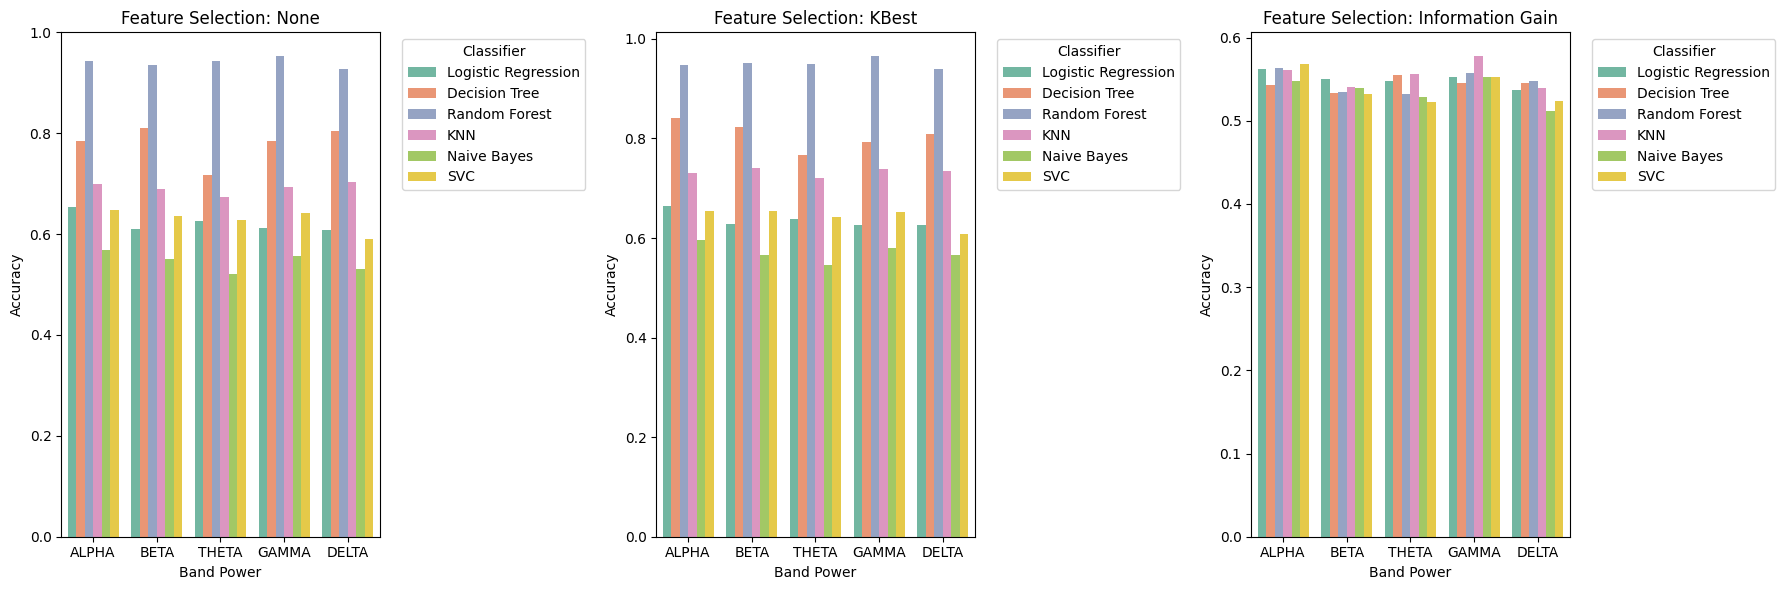

In [ ]:
accuracy_df["Feature Selection Method"] = "None"
accuracies_with_kbest["Feature Selection Method"] = "KBest"
accuracies_with_information_gain["Feature Selection Method"] = "Information Gain"
combined_df = pd.concat([accuracy_df, accuracies_with_kbest, accuracies_with_information_gain])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

methods = ['None', 'KBest', 'Information Gain']
for i, method in enumerate(methods):
	method_data = combined_df[combined_df["Feature Selection Method"] == method]

	sns.barplot(x="Band Power", y="Accuracy", hue="Model", data=method_data, ci=None, palette="Set2", ax=axes[i])
	
	axes[i].set_title(f"Feature Selection: {method}")
	axes[i].set_xlabel("Band Power")
	axes[i].set_ylabel("Accuracy")
	axes[i].legend(title="Classifier", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()